# MTCNN with landmark (should be used folloed MTCNN)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import os
import numpy as np
#image loader
class ImageDB(object):
    def __init__(self, image_annotation_file, prefix_path='', mode='train'):
        self.prefix_path = prefix_path
        self.image_annotation_file = image_annotation_file
        self.classes = ['__background__', 'face']
        self.num_classes = 2
        self.image_set_index = self.load_image_set_index()
        self.num_images = len(self.image_set_index)
        self.mode = mode
        print(self.num_images)


    def load_image_set_index(self):
        
        assert os.path.exists(self.image_annotation_file), 'Path does not exist: {}'.format(self.image_annotation_file)
        with open(self.image_annotation_file, 'r') as f:
            image_set_index = [x.strip().split(' ')[0] for x in f.readlines()]
        return image_set_index


    def load_imdb(self):
        
        gt_imdb = self.load_annotations()
        return gt_imdb


    def real_image_path(self, index):
       
        index = index.replace("\\", "/")

        if not os.path.exists(index):
            image_file = os.path.join(self.prefix_path, index)
        else:
            image_file=index
        if not image_file.endswith('.jpg'):
            image_file = image_file + '.jpg'
        assert os.path.exists(image_file), 'Path does not exist: {}'.format(image_file)
        return image_file


    def load_annotations(self,annotion_type=1):
      
        assert os.path.exists(self.image_annotation_file), 'annotations not found at {}'.format(self.image_annotation_file)
        with open(self.image_annotation_file, 'r') as f:
            annotations = f.readlines()

        imdb = []
        number = self.num_images###############control the number of images reader
        for i in range(number):
            annotation = annotations[i].strip().split(' ')
            if i%10000==0:
                print(i)
            index = annotation[0]
            im_path = self.real_image_path(index)
            imdb_ = dict()
            imdb_['image'] = im_path

            if self.mode == 'test':
                pass
            else:
                label = annotation[1]
                imdb_['label'] = int(label)
                imdb_['flipped'] = False
                imdb_['bbox_target'] = np.zeros((4,))
                imdb_['landmark_target'] = np.zeros((10,))
                if len(annotation[2:])==4:
                    bbox_target = annotation[2:6]
                    imdb_['bbox_target'] = np.array(bbox_target).astype(float)
                if len(annotation[2:])==14:
                    bbox_target = annotation[2:6]
                    imdb_['bbox_target'] = np.array(bbox_target).astype(float)
                    landmark = annotation[6:]
                    imdb_['landmark_target'] = np.array(landmark).astype(float)
            imdb.append(imdb_)

        return imdb


    def append_flipped_images(self, imdb):
       
        print('append flipped images to imdb', len(imdb))
        for i in range(len(imdb)):
            imdb_ = imdb[i]
            m_bbox = imdb_['bbox_target'].copy()
            m_bbox[0], m_bbox[2] = -m_bbox[2], -m_bbox[0]

            landmark_ = imdb_['landmark_target'].copy()
            landmark_ = landmark_.reshape((5, 2))
            landmark_ = np.asarray([(1 - x, y) for (x, y) in landmark_])
            landmark_[[0, 1]] = landmark_[[1, 0]]
            landmark_[[3, 4]] = landmark_[[4, 3]]

            item = {'image': imdb_['image'],
                     'label': imdb_['label'],
                     'bbox_target': m_bbox,
                     'landmark_target': landmark_.reshape((10)),
                     'flipped': True}

            imdb.append(item)
        self.image_set_index *= 2
        return imdb

In [3]:
import numpy as np
import cv2
#image reader


class TrainImageReader:
    def __init__(self, imdb, im_size, batch_size=128, shuffle=False):

        self.imdb = imdb
        self.batch_size = batch_size
        self.im_size = im_size
        self.shuffle = shuffle

        self.cur = 0
        self.size = len(imdb)
        self.index = np.arange(self.size)
        self.num_classes = 2

        self.batch = None
        self.data = None
        self.label = None

        self.label_names= ['label', 'bbox_target', 'landmark_target']
        self.reset()
        self.get_batch()

    def reset(self):
        self.cur = 0
        if self.shuffle:
            np.random.shuffle(self.index)

    def iter_next(self):
        return self.cur + self.batch_size <= self.size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self.iter_next():
            self.get_batch()
            self.cur += self.batch_size
            return self.data,self.label
        else:
            raise StopIteration

    def getindex(self):
        return self.cur / self.batch_size

    def getpad(self):
        if self.cur + self.batch_size > self.size:
            return self.cur + self.batch_size - self.size
        else:
            return 0

    def get_batch(self):
        cur_from = self.cur
        cur_to = min(cur_from + self.batch_size, self.size)
        imdb = [self.imdb[self.index[i]] for i in range(cur_from, cur_to)]
        data, label = get_minibatch(imdb)
        self.data = data['data']
        self.label = [label[name] for name in self.label_names]



class TestImageLoader:
    def __init__(self, imdb, batch_size=1, shuffle=False):
        self.imdb = imdb
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.size = len(imdb)
        self.index = np.arange(self.size)

        self.cur = 0
        self.data = None
        self.label = None

        self.reset()
        self.get_batch()

    def reset(self):
        self.cur = 0
        if self.shuffle:
            np.random.shuffle(self.index)

    def iter_next(self):
        return self.cur + self.batch_size <= self.size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self.iter_next():
            self.get_batch()
            self.cur += self.batch_size
            return self.data
        else:
            raise StopIteration

    def getindex(self):
        return self.cur / self.batch_size

    def getpad(self):
        if self.cur + self.batch_size > self.size:
            return self.cur + self.batch_size - self.size
        else:
            return 0

    def get_batch(self):
        cur_from = self.cur
        cur_to = min(cur_from + self.batch_size, self.size)
        imdb = [self.imdb[self.index[i]] for i in range(cur_from, cur_to)]
        data= get_testbatch(imdb)
        self.data=data['data']




def get_minibatch(imdb):

    # im_size: 12, 24 or 48
    num_images = len(imdb)
    processed_ims = list()
    cls_label = list()
    bbox_reg_target = list()
    landmark_reg_target = list()

    for i in range(num_images):
        im = cv2.imread(imdb[i]['image'])
        #im = Image.open(imdb[i]['image'])

        if imdb[i]['flipped']:
            im = im[:, ::-1, :]
            #im = im.transpose(Image.FLIP_LEFT_RIGHT)

        cls = imdb[i]['label']
        bbox_target = imdb[i]['bbox_target']
        landmark = imdb[i]['landmark_target']

        processed_ims.append(im)
        cls_label.append(cls)
        bbox_reg_target.append(bbox_target)
        landmark_reg_target.append(landmark)

    im_array = np.asarray(processed_ims)

    label_array = np.array(cls_label)

    bbox_target_array = np.vstack(bbox_reg_target)

    landmark_target_array = np.vstack(landmark_reg_target)

    data = {'data': im_array}
    label = {'label': label_array,
             'bbox_target': bbox_target_array,
             'landmark_target': landmark_target_array
             }

    return data, label


def get_testbatch(imdb):
    assert len(imdb) == 1, "Single batch only"
    im = cv2.imread(imdb[0]['image'])
    data = {'data': im}
    return data

In [4]:
import os
import numpy.random as npr
import numpy as np

def assemble_data(output_file, anno_file_list=[]):

    #assemble the pos, neg, part annotations to one file
    size = 12

    if len(anno_file_list)==0:
        return 0

    if os.path.exists(output_file):
        os.remove(output_file)

    for anno_file in anno_file_list:
        with open(anno_file, 'r') as f:
            print(anno_file)
            anno_lines = f.readlines()

        base_num = 250000

        if len(anno_lines) > base_num * 3:
            idx_keep = npr.choice(len(anno_lines), size=base_num * 3, replace=True)
        elif len(anno_lines) > 100000:
            idx_keep = npr.choice(len(anno_lines), size=len(anno_lines), replace=True)
        else:
            idx_keep = np.arange(len(anno_lines))
            np.random.shuffle(idx_keep)
        chose_count = 0
        with open(output_file, 'a+') as f:
            for idx in idx_keep:
                f.write(anno_lines[idx])
                chose_count+=1

    return chose_count

In [5]:
import torchvision.transforms as transforms
import torch
from torch.autograd.variable import Variable
import numpy as np

transform = transforms.ToTensor()

def convert_image_to_tensor(image):
    """convert an image to pytorch tensor
        Parameters:
        ----------
        image: numpy array , h * w * c
        Returns:
        -------
        image_tensor: pytorch.FloatTensor, c * h * w
        """
    # image = image.astype(np.float32)
    return transform(image)
    # return transform(image)


def convert_chwTensor_to_hwcNumpy(tensor):
    """convert a group images pytorch tensor(count * c * h * w) to numpy array images(count * h * w * c)
            Parameters:
            ----------
            tensor: numpy array , count * c * h * w
            Returns:
            -------
            numpy array images: count * h * w * c
            """

    if isinstance(tensor, Variable):
        return np.transpose(tensor.data.numpy(), (0,2,3,1))
    elif isinstance(tensor, torch.FloatTensor):
        return np.transpose(tensor.numpy(), (0,2,3,1))
    else:
        raise Exception("covert b*c*h*w tensor to b*h*w*c numpy error.This tensor must have 4 dimension.")

In [6]:
import numpy as np
# the basic tools
def IoU(box, boxes):
    # box = (x1, y1, x2, y2)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    
    # the offset of the interception of union between crop_box and gt_box
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = np.true_divide(inter,(box_area + area - inter))
    return ovr


def convert_to_square(bbox):
    
    square_bbox = bbox.copy()

    h = bbox[:, 3] - bbox[:, 1] + 1
    w = bbox[:, 2] - bbox[:, 0] + 1
    max_side = np.maximum(h,w)
    square_bbox[:, 0] = bbox[:, 0] + w*0.5 - max_side*0.5
    square_bbox[:, 1] = bbox[:, 1] + h*0.5 - max_side*0.5
    square_bbox[:, 2] = square_bbox[:, 0] + max_side - 1
    square_bbox[:, 3] = square_bbox[:, 1] + max_side - 1
    return square_bbox

def nms(dets, thresh, mode="Union"):
    
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] 
   
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        
        if mode == "Union":
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
        elif mode == "Minimum":
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1] 
        # print(inds)
        
    return keep


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#net and the loss function
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data)
        nn.init.constant(m.bias, 0.1)



class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):
        # loss function
        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss() # binary cross entropy
        self.loss_box = nn.MSELoss() # mean square error
        self.loss_landmark = nn.MSELoss()


    def cls_loss(self,gt_label,pred_label):
        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        # get the mask element which >= 0, only 0 and 1 can effect the detection loss
        mask = torch.ge(gt_label,0)
        valid_gt_label = torch.masked_select(gt_label,mask)
        valid_pred_label = torch.masked_select(pred_label,mask)
        return self.loss_cls(valid_pred_label,valid_gt_label)*self.cls_factor


    def box_loss(self,gt_label,gt_offset,pred_offset):
        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)

        #get the mask element which != 0
        unmask = torch.eq(gt_label,0)
        mask = torch.eq(unmask,0)
        #convert mask to dim index
        chose_index = torch.nonzero(mask.data)
        chose_index = torch.squeeze(chose_index)
        #only valid element can effect the loss
        valid_gt_offset = gt_offset[chose_index,:]
        valid_pred_offset = pred_offset[chose_index,:]
        return self.loss_box(valid_pred_offset,valid_gt_offset)*self.box_factor


    def landmark_loss(self,gt_label,gt_landmark,pred_landmark):
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(gt_label)
        mask = torch.eq(gt_label,-2)

        chose_index = torch.nonzero(mask.data)
        chose_index = torch.squeeze(chose_index)

        valid_gt_landmark = gt_landmark[chose_index, :]
        valid_pred_landmark = pred_landmark[chose_index, :]
        return self.loss_landmark(valid_pred_landmark,valid_gt_landmark)*self.land_factor





class PNet(nn.Module):
    ''' PNet '''

    def __init__(self, is_train=False, use_cuda=True):
        super(PNet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda

        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool1
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # PReLU2
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # conv3
            nn.PReLU()  # PReLU3
        )
        # detection
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        # bounding box regresion
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        # landmark localization
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)

        # weight initiation with xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        label = F.sigmoid(self.conv4_1(x))
        offset = self.conv4_2(x)
        # landmark = self.conv4_3(x)

        if self.is_train is True:
            # label_loss = LossUtil.label_loss(self.gt_label,torch.squeeze(label))
            # bbox_loss = LossUtil.bbox_loss(self.gt_bbox,torch.squeeze(offset))
            return label,offset
        #landmark = self.conv4_3(x)
        return label, offset





class RNet(nn.Module):
    ''' RNet '''

    def __init__(self,is_train=False, use_cuda=True):
        super(RNet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda
        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  # conv3
            nn.PReLU()  # prelu3

        )
        self.conv4 = nn.Linear(64*2*2, 128)  # conv4
        self.prelu4 = nn.PReLU()  # prelu4
        # detection
        self.conv5_1 = nn.Linear(128, 1)
        # bounding box regression
        self.conv5_2 = nn.Linear(128, 4)
        # lanbmark localization
        self.conv5_3 = nn.Linear(128, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        # backend
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        # detection
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        # landmark = self.conv5_3(x)

        if self.is_train is True:
            return det, box
        #landmard = self.conv5_3(x)
        return det, box




class ONet(nn.Module):
    ''' RNet '''

    def __init__(self,is_train=False, use_cuda=True):
        super(ONet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda
        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(), # prelu3
            nn.MaxPool2d(kernel_size=2,stride=2), # pool3
            nn.Conv2d(64,128,kernel_size=2,stride=1), # conv4
            nn.PReLU() # prelu4
        )
        self.conv5 = nn.Linear(128*2*2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5
        # detection
        self.conv6_1 = nn.Linear(256, 1)
        # bounding box regression
        self.conv6_2 = nn.Linear(256, 4)
        # lanbmark localization
        self.conv6_3 = nn.Linear(256, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        # backend
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        # detection
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        if self.is_train is True:
            return det, box, landmark
        #landmard = self.conv5_3(x)
        return det, box, landmark





# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out



# ResNet Module
class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, 16,kernel_size=3)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, 3)
        self.layer2 = self.make_layer(block, 32, 3, 2)
        self.layer3 = self.make_layer(block, 64, 3, 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
import datetime
import os
import torch
from torch.autograd import Variable
import numpy as np

# train net
def compute_accuracy(prob_cls, gt_cls):

    prob_cls = torch.squeeze(prob_cls)
    gt_cls = torch.squeeze(gt_cls)

    #we only need the detection which >= 0
    mask = torch.ge(gt_cls,0)
    #get valid element
    valid_gt_cls = torch.masked_select(gt_cls,mask)
    valid_prob_cls = torch.masked_select(prob_cls,mask)
    size = min(valid_gt_cls.size()[0], valid_prob_cls.size()[0])
    prob_ones = torch.ge(valid_prob_cls,0.6).float()
    right_ones = torch.eq(prob_ones,valid_gt_cls).float()

    ## if size == 0 meaning that your gt_labels are all negative, landmark or part

    return torch.div(torch.mul(torch.sum(right_ones),float(1.0)),float(size))  ## divided by zero meaning that your gt_labels are all negative, landmark or part


def train_pnet(model_store_path, end_epoch,imdb,
              batch_size,frequent=10,base_lr=0.01,lr_epoch_decay=[9],use_cuda=True,load=''):
    
    lr_epoch_decay.append(end_epoch+1)
    lr_list = np.zeros(end_epoch)
    lr_t = base_lr
    for i in range(len(lr_epoch_decay)):
        if i==0:
            lr_list[0:lr_epoch_decay[i]-1]=lr_t
        else:
            lr_list[lr_epoch_decay[i-1]-1:lr_epoch_decay[i]-1]=lr_t
        lr_t*=0.1

    if not os.path.exists(model_store_path):
        os.makedirs(model_store_path)

    lossfn = LossFn()
    net = PNet(is_train=True, use_cuda=use_cuda)
    if load!='':
        net.load_state_dict(torch.load(load))
        print('model loaded',load)
    net.train()

    if use_cuda:
        net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_list[0])

    train_data=TrainImageReader(imdb,12,batch_size,shuffle=True)

    frequent = 10
    for cur_epoch in range(1,end_epoch+1):
        train_data.reset() # shuffle

        for batch_idx,(image,(gt_label,gt_bbox,gt_landmark))in enumerate(train_data):

            im_tensor = [convert_image_to_tensor(image[i,:,:,:]) for i in range(image.shape[0])]
            im_tensor = torch.stack(im_tensor)

            im_tensor = Variable(im_tensor)
            gt_label = Variable(torch.from_numpy(gt_label).float())

            gt_bbox = Variable(torch.from_numpy(gt_bbox).float())
            # gt_landmark = Variable(torch.from_numpy(gt_landmark).float())

            if use_cuda:
                im_tensor = im_tensor.cuda()
                gt_label = gt_label.cuda()
                gt_bbox = gt_bbox.cuda()
                # gt_landmark = gt_landmark.cuda()

            cls_pred, box_offset_pred = net(im_tensor)
            # all_loss, cls_loss, offset_loss = lossfn.loss(gt_label=label_y,gt_offset=bbox_y, pred_label=cls_pred, pred_offset=box_offset_pred)

            cls_loss = lossfn.cls_loss(gt_label,cls_pred)
            box_offset_loss = lossfn.box_loss(gt_label,gt_bbox,box_offset_pred)
            # landmark_loss = lossfn.landmark_loss(gt_label,gt_landmark,landmark_offset_pred)

            all_loss = cls_loss*1.0+box_offset_loss*0.5

            if batch_idx %frequent==0:
                accuracy=compute_accuracy(cls_pred,gt_label)

                show1 = accuracy.data.cpu().numpy()
                show2 = cls_loss.data.cpu().numpy()
                show3 = box_offset_loss.data.cpu().numpy()
                # show4 = landmark_loss.data.cpu().numpy()
                show5 = all_loss.data.cpu().numpy()

                print("%s : Epoch: %d, Step: %d, accuracy: %s, det loss: %s, bbox loss: %s, all_loss: %s, lr:%s "%(datetime.datetime.now(),cur_epoch,batch_idx, show1,show2,show3,show5,lr_list[cur_epoch-1]))

            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

        torch.save(net.state_dict(), os.path.join(model_store_path,"pnet_epoch_%d.pt" % cur_epoch))
        torch.save(net, os.path.join(model_store_path,"pnet_epoch_model_%d.pkl" % cur_epoch))




def train_rnet(model_store_path, end_epoch,imdb,
              batch_size,frequent=50,base_lr=0.01,lr_epoch_decay=[9],use_cuda=True):
    lr_epoch_decay.append(end_epoch+1)
    lr_list = np.zeros(end_epoch)
    lr_t = base_lr
    for i in range(len(lr_epoch_decay)):
        if i==0:
            lr_list[0:lr_epoch_decay[i]-1]=lr_t
        else:
            lr_list[lr_epoch_decay[i-1]-1:lr_epoch_decay[i]-1]=lr_t
        lr_t*=0.1
    print(lr_list)
    
    
    if not os.path.exists(model_store_path):
        os.makedirs(model_store_path)

    lossfn = LossFn()
    net = RNet(is_train=True, use_cuda=use_cuda)
    net.train()
    if load!='':
        net.load_state_dict(torch.load(load))
        print('model loaded',load)
    if use_cuda:
        net.cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=base_lr)

    train_data=TrainImageReader(imdb,24,batch_size,shuffle=True)


    for cur_epoch in range(1,end_epoch+1):
        train_data.reset()
        for param in optimizer.param_groups:
            param['lr'] = lr_list[cur_epoch-1]
        for batch_idx,(image,(gt_label,gt_bbox,gt_landmark))in enumerate(train_data):

            im_tensor = [convert_image_to_tensor(image[i,:,:,:]) for i in range(image.shape[0])]
            im_tensor = torch.stack(im_tensor)

            im_tensor = Variable(im_tensor)
            gt_label = Variable(torch.from_numpy(gt_label).float())

            gt_bbox = Variable(torch.from_numpy(gt_bbox).float())
            gt_landmark = Variable(torch.from_numpy(gt_landmark).float())

            if use_cuda:
                im_tensor = im_tensor.cuda()
                gt_label = gt_label.cuda()
                gt_bbox = gt_bbox.cuda()
                gt_landmark = gt_landmark.cuda()

            cls_pred, box_offset_pred = net(im_tensor)
            # all_loss, cls_loss, offset_loss = lossfn.loss(gt_label=label_y,gt_offset=bbox_y, pred_label=cls_pred, pred_offset=box_offset_pred)

            cls_loss = lossfn.cls_loss(gt_label,cls_pred)
            box_offset_loss = lossfn.box_loss(gt_label,gt_bbox,box_offset_pred)
            # landmark_loss = lossfn.landmark_loss(gt_label,gt_landmark,landmark_offset_pred)

            all_loss = cls_loss*1.0+box_offset_loss*0.5

            if batch_idx%frequent==0:
                accuracy=compute_accuracy(cls_pred,gt_label)

                show1 = accuracy.data.cpu().numpy()
                show2 = cls_loss.data.cpu().numpy()
                show3 = box_offset_loss.data.cpu().numpy()
                # show4 = landmark_loss.data.cpu().numpy()
                show5 = all_loss.data.cpu().numpy()

                print("%s : Epoch: %d, Step: %d, accuracy: %s, det loss: %s, bbox loss: %s, all_loss: %s, lr:%s "%(datetime.datetime.now(), cur_epoch, batch_idx, show1, show2, show3, show5, lr_list[cur_epoch-1]))

            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

        torch.save(net.state_dict(), os.path.join(model_store_path,"rnet_epoch_%d.pt" % cur_epoch))
        torch.save(net, os.path.join(model_store_path,"rnet_epoch_model_%d.pkl" % cur_epoch))


def train_onet(model_store_path, end_epoch,imdb,
              batch_size,frequent=50,base_lr=0.01,lr_epoch_decay=[9],use_cuda=True):
    lr_epoch_decay.append(end_epoch+1)
    lr_list = np.zeros(end_epoch)
    lr_t = base_lr
    for i in range(len(lr_epoch_decay)):
        if i==0:
            lr_list[0:lr_epoch_decay[i]-1]=lr_t
        else:
            lr_list[lr_epoch_decay[i-1]-1:lr_epoch_decay[i]-1]=lr_t
        lr_t*=0.1

    
    if not os.path.exists(model_store_path):
        os.makedirs(model_store_path)

    lossfn = LossFn()
    net = ONet(is_train=True)
    net.train()
    if load!='':
        net.load_state_dict(torch.load(load))
        print('model loaded',load)
    if use_cuda:
        net.cuda()
    print(use_cuda)
    if use_cuda:
        net.cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=base_lr)

    train_data=TrainImageReader(imdb,48,batch_size,shuffle=True)


    for cur_epoch in range(1,end_epoch+1):

        train_data.reset()
        for param in optimizer.param_groups:
            param['lr'] = lr_list[cur_epoch-1]
            
        for batch_idx,(image,(gt_label,gt_bbox,gt_landmark))in enumerate(train_data):
            # print("batch id {0}".format(batch_idx))
            im_tensor = [  convert_image_to_tensor(image[i,:,:,:]) for i in range(image.shape[0]) ]
            im_tensor = torch.stack(im_tensor)

            im_tensor = Variable(im_tensor)
            gt_label = Variable(torch.from_numpy(gt_label).float())

            gt_bbox = Variable(torch.from_numpy(gt_bbox).float())
            gt_landmark = Variable(torch.from_numpy(gt_landmark).float())
           # print('gt_landmark')#################################################################
            #print(gt_landmark)

            if use_cuda:
                im_tensor = im_tensor.cuda()
                gt_label = gt_label.cuda()
                gt_bbox = gt_bbox.cuda()
                gt_landmark = gt_landmark.cuda()

            cls_pred, box_offset_pred, landmark_offset_pred = net(im_tensor)
            #print(landmark_offset_pred)####################################################################################

            # all_loss, cls_loss, offset_loss = lossfn.loss(gt_label=label_y,gt_offset=bbox_y, pred_label=cls_pred, pred_offset=box_offset_pred)

            cls_loss = lossfn.cls_loss(gt_label,cls_pred)
            box_offset_loss = lossfn.box_loss(gt_label,gt_bbox,box_offset_pred)
            landmark_loss = lossfn.landmark_loss(gt_label,gt_landmark,landmark_offset_pred)

            all_loss = cls_loss*0.8+box_offset_loss*0.6+landmark_loss*1.5

            if batch_idx%frequent==0:
                accuracy=compute_accuracy(cls_pred,gt_label)
                
                show1 = accuracy.data.cpu().numpy()
                show2 = cls_loss.data.cpu().numpy()
                show3 = box_offset_loss.data.cpu().numpy()
                show4 = landmark_loss.data.cpu().numpy()
                show5 = all_loss.data.cpu().numpy()

                print("%s : Epoch: %d, Step: %d, accuracy: %s, det loss: %s, bbox loss: %s, landmark loss: %s, all_loss: %s, lr:%s "%(datetime.datetime.now(),cur_epoch,batch_idx, show1,show2,show3,show4,show5,lr_list[cur_epoch-1]))

            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

        torch.save(net.state_dict(), os.path.join(model_store_path,"onet_epoch_%d.pt" % cur_epoch))
        torch.save(net, os.path.join(model_store_path,"onet_epoch_model_%d.pkl" % cur_epoch))

In [9]:
import cv2
import time
import numpy as np
import torch
from torch.autograd.variable import Variable
# create the whole mtcnn
def create_mtcnn_net(p_model_path=None, r_model_path=None, o_model_path=None, use_cuda=True):

    pnet, rnet, onet = None, None, None

    if p_model_path is not None:
        pnet = PNet(use_cuda=use_cuda)
        if(use_cuda):
            print('p_model_path:{0}'.format(p_model_path))
            pnet.load_state_dict(torch.load(p_model_path))
            pnet.cuda()
        else:
            
            pnet.load_state_dict(torch.load(p_model_path, map_location='cpu'))
        pnet.eval()

    if r_model_path is not None:
        rnet = RNet(use_cuda=use_cuda)
        if (use_cuda):
            print('r_model_path:{0}'.format(r_model_path))
            rnet.load_state_dict(torch.load(r_model_path))
            rnet.cuda()
        else:
            rnet.load_state_dict(torch.load(r_model_path, map_location=lambda storage, loc: storage))
        rnet.eval()

    if o_model_path is not None:
        onet = ONet(use_cuda=use_cuda)
        if (use_cuda):
            print('o_model_path:{0}'.format(o_model_path))
            onet.load_state_dict(torch.load(o_model_path))
            onet.cuda()
        else:
            onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
        onet.eval()

    return pnet,rnet,onet


class MtcnnDetector(object):
    """
        P,R,O net face detection and landmarks align
    """
    def  __init__(self,
                 pnet = None,
                 rnet = None,
                 onet = None,
                 min_face_size=12,
                 stride=2,
                 threshold=[0.6, 0.7, 0.7],
                 scale_factor=0.709,
                 ):

        self.pnet_detector = pnet
        self.rnet_detector = rnet
        self.onet_detector = onet
        self.min_face_size = min_face_size
        self.stride=stride
        self.thresh = threshold
        self.scale_factor = scale_factor


    def unique_image_format(self,im):
        if not isinstance(im,np.ndarray):
            if im.mode == 'I':
                im = np.array(im, np.int32, copy=False)
            elif im.mode == 'I;16':
                im = np.array(im, np.int16, copy=False)
            else:
                im = np.asarray(im)
        return im

    def square_bbox(self, bbox):
        
        square_bbox = bbox.copy()

        
        
        h = bbox[:, 3] - bbox[:, 1] + 1# x2 - x1
        w = bbox[:, 2] - bbox[:, 0] + 1# y2 - y1
        l = np.maximum(h,w)
        square_bbox[:, 0] = bbox[:, 0] + w*0.5 - l*0.5
        square_bbox[:, 1] = bbox[:, 1] + h*0.5 - l*0.5

        # x2 = x1 + l - 1
        # y2 = y1 + l - 1
        square_bbox[:, 2] = square_bbox[:, 0] + l - 1
        square_bbox[:, 3] = square_bbox[:, 1] + l - 1
        return square_bbox


    def generate_bounding_box(self, map, reg, scale, threshold):
        
        stride = 2
        cellsize = 12 # receptive field

        t_index = np.where(map[:,:,0] > threshold)
        
        if t_index[0].size == 0:
            return np.array([])

        
        dx1, dy1, dx2, dy2 = [reg[0, t_index[0], t_index[1], i] for i in range(4)]
        
        reg = np.array([dx1, dy1, dx2, dy2])
        
        score = map[t_index[0], t_index[1], 0]

      
        boundingbox = np.vstack([np.round((stride * t_index[1]) / scale),            # x1 of prediction box in original image
                                 np.round((stride * t_index[0]) / scale),            # y1 of prediction box in original image
                                 np.round((stride * t_index[1] + cellsize) / scale), # x2 of prediction box in original image
                                 np.round((stride * t_index[0] + cellsize) / scale), # y2 of prediction box in original image
                                                                                     # reconstruct the box in original image
                                 score,
                                 reg,
                                
                                 ])

        return boundingbox.T


    def resize_image(self, img, scale):
        #resize nd transform
        height, width, channels = img.shape
        new_height = int(height * scale)     # resized new height
        new_width = int(width * scale)       # resized new width
        new_dim = (new_width, new_height)
        img_resized = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR)      # resized image
        return img_resized


    def pad(self, bboxes, w, h):
        
        # width and height
        tmpw = (bboxes[:, 2] - bboxes[:, 0] + 1).astype(np.int32)
        tmph = (bboxes[:, 3] - bboxes[:, 1] + 1).astype(np.int32)
        numbox = bboxes.shape[0]

        dx = np.zeros((numbox, ))
        dy = np.zeros((numbox, ))
        edx, edy  = tmpw.copy()-1, tmph.copy()-1
        
        x, y, ex, ey = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]

        tmp_index = np.where(ex > w-1)
        edx[tmp_index] = tmpw[tmp_index] + w - 2 - ex[tmp_index]
        ex[tmp_index] = w - 1

        tmp_index = np.where(ey > h-1)
        edy[tmp_index] = tmph[tmp_index] + h - 2 - ey[tmp_index]
        ey[tmp_index] = h - 1

        tmp_index = np.where(x < 0)
        dx[tmp_index] = 0 - x[tmp_index]
        x[tmp_index] = 0

        tmp_index = np.where(y < 0)
        dy[tmp_index] = 0 - y[tmp_index]
        y[tmp_index] = 0

        return_list = [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph]
        return_list = [item.astype(np.int32) for item in return_list]

        return return_list


    def detect_pnet(self, im):
       #face box candidate detection

        # original wider face data
        h, w, c = im.shape

        net_size = 12

        current_scale = float(net_size) / self.min_face_size    # find initial scale
        im_resized = self.resize_image(im, current_scale) 
        current_height, current_width, _ = im_resized.shape

        # fcn
        all_boxes = list()
        
        while min(current_height, current_width) > net_size:
            # print(i)
            feed_imgs = []
            image_tensor =  convert_image_to_tensor(im_resized)
            feed_imgs.append(image_tensor)
            feed_imgs = torch.stack(feed_imgs)
            feed_imgs = Variable(feed_imgs)

            if self.pnet_detector.use_cuda:
                feed_imgs = feed_imgs.cuda()

           
            cls_map, reg = self.pnet_detector(feed_imgs)

            cls_map_np =  convert_chwTensor_to_hwcNumpy(cls_map.cpu())
            reg_np =  convert_chwTensor_to_hwcNumpy(reg.cpu())
            
            boxes = self.generate_bounding_box(cls_map_np[ 0, :, :], reg_np, current_scale, self.thresh[0])

            # generate pyramid images
            current_scale *= self.scale_factor 
            im_resized = self.resize_image(im, current_scale)
            current_height, current_width, _ = im_resized.shape

            if boxes.size == 0:
                continue

            # non-maximum suppresion
            keep = nms(boxes[:, :5], 0.5, 'Union')
            boxes = boxes[keep]
            # print(boxes.shape)
            all_boxes.append(boxes)
 

        if len(all_boxes) == 0:
            return None, None

        all_boxes = np.vstack(all_boxes)
       
        # merge the detection from first stage
        keep = nms(all_boxes[:, 0:5], 0.7, 'Union')
        all_boxes = all_boxes[keep]
        
        bw = all_boxes[:, 2] - all_boxes[:, 0] + 1
        bh = all_boxes[:, 3] - all_boxes[:, 1] + 1




        boxes = np.vstack([all_boxes[:,0],
                   all_boxes[:,1],
                   all_boxes[:,2],
                   all_boxes[:,3],
                   all_boxes[:,4],
                   
                  ])

        boxes = boxes.T

        # boxes = boxes = [x1, y1, x2, y2, score, reg] reg= [px1, py1, px2, py2] (in prediction)
        align_topx = all_boxes[:, 0] + all_boxes[:, 5] * bw
        align_topy = all_boxes[:, 1] + all_boxes[:, 6] * bh
        align_bottomx = all_boxes[:, 2] + all_boxes[:, 7] * bw
        align_bottomy = all_boxes[:, 3] + all_boxes[:, 8] * bh

        # refine the boxes
        boxes_align = np.vstack([ align_topx,
                              align_topy,
                              align_bottomx,
                              align_bottomy,
                              all_boxes[:, 4],
                             
                              ])
        boxes_align = boxes_align.T
        
        #remove invalid box
        valindex = [True for _ in range(boxes_align.shape[0])]   
        for i in range(boxes_align.shape[0]):
            if boxes_align[i][2]-boxes_align[i][0]<=3 or boxes_align[i][3]-boxes_align[i][1]<=3:
                valindex[i]=False
                print('pnet has one smaller than 3')
            else:
                if boxes_align[i][2]<1 or boxes_align[i][0]>w-2 or boxes_align[i][3]<1 or boxes_align[i][1]>h-2:
                    valindex[i]=False
                    print('pnet has one out')
        boxes_align=boxes_align[valindex,:]
        boxes = boxes[valindex,:]

        return boxes, boxes_align

    def detect_rnet(self, im, dets):
       #seect the face box candidate
        # im: an input image
        h, w, c = im.shape

        if dets is None:
            return None,None
        if dets.shape[0]==0:
            return None, None

        # return square boxes
        dets = self.square_bbox(dets)
        # rounds
        dets[:, 0:4] = np.round(dets[:, 0:4])

        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(dets, w, h)
        num_boxes = dets.shape[0]

        # cropped_ims_tensors = np.zeros((num_boxes, 3, 24, 24), dtype=np.float32)
        cropped_ims_tensors = []
        for i in range(num_boxes):
            try:
                tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
                tmp[dy[i]:edy[i]+1, dx[i]:edx[i]+1, :] = im[y[i]:ey[i]+1, x[i]:ex[i]+1, :]
            except:    
                print(dy[i],edy[i],dx[i],edx[i],y[i],ey[i],x[i],ex[i],tmpw[i],tmph[i])
                print(dets[i])
                print(detss[i])
                print(detsss[i])
                print(h,w)
                exit()
            crop_im = cv2.resize(tmp, (24, 24))
            crop_im_tensor = convert_image_to_tensor(crop_im)
            
            cropped_ims_tensors.append(crop_im_tensor)
        feed_imgs = Variable(torch.stack(cropped_ims_tensors))

        if self.rnet_detector.use_cuda:
            feed_imgs = feed_imgs.cuda()

        cls_map, reg = self.rnet_detector(feed_imgs)

        cls_map = cls_map.cpu().data.numpy()
        reg = reg.cpu().data.numpy()

        keep_inds = np.where(cls_map > self.thresh[1])[0]

        if len(keep_inds) > 0:
            boxes = dets[keep_inds]
            cls = cls_map[keep_inds]
            reg = reg[keep_inds]
           
        else:
            return None, None

        keep = nms(boxes, 0.7)

        if len(keep) == 0:
            return None, None

        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
     


        bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
        bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1


        boxes = np.vstack([ keep_boxes[:,0],
                              keep_boxes[:,1],
                              keep_boxes[:,2],
                              keep_boxes[:,3],
                              keep_cls[:,0],
                             
                            ])

        align_topx = keep_boxes[:,0] + keep_reg[:,0] * bw
        align_topy = keep_boxes[:,1] + keep_reg[:,1] * bh
        align_bottomx = keep_boxes[:,2] + keep_reg[:,2] * bw
        align_bottomy = keep_boxes[:,3] + keep_reg[:,3] * bh

        boxes_align = np.vstack([align_topx,
                               align_topy,
                               align_bottomx,
                               align_bottomy,
                               keep_cls[:, 0],
                               
                             ])

        boxes = boxes.T
        boxes_align = boxes_align.T
        #remove invalid box
        valindex = [True for _ in range(boxes_align.shape[0])]   
        for i in range(boxes_align.shape[0]):
            if boxes_align[i][2]-boxes_align[i][0]<=3 or boxes_align[i][3]-boxes_align[i][1]<=3:
                valindex[i]=False
                print('rnet has one smaller than 3')
            else:
                if boxes_align[i][2]<1 or boxes_align[i][0]>w-2 or boxes_align[i][3]<1 or boxes_align[i][1]>h-2:
                    valindex[i]=False
                    print('rnet has one out')
        boxes_align=boxes_align[valindex,:]
        boxes = boxes[valindex,:]

        return boxes, boxes_align

    def detect_onet(self, im, dets):
        # get the final face box
        h, w, c = im.shape

        if dets is None:
            return None, None
        if dets.shape[0]==0:
            return None, None

        dets = self.square_bbox(dets)
        dets[:, 0:4] = np.round(dets[:, 0:4])

        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(dets, w, h)
        num_boxes = dets.shape[0]


        # cropped_ims_tensors = np.zeros((num_boxes, 3, 24, 24), dtype=np.float32)
        cropped_ims_tensors = []
        for i in range(num_boxes):
            try:
                tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
                # crop input image
                tmp[dy[i]:edy[i] + 1, dx[i]:edx[i] + 1, :] = im[y[i]:ey[i] + 1, x[i]:ex[i] + 1, :]
            except:
                print(dy[i],edy[i],dx[i],edx[i],y[i],ey[i],x[i],ex[i],tmpw[i],tmph[i])
                print(dets[i])
                print(detss[i])
                print(h,w)
            crop_im = cv2.resize(tmp, (48, 48))
            crop_im_tensor = convert_image_to_tensor(crop_im)
           
            cropped_ims_tensors.append(crop_im_tensor)
        feed_imgs = Variable(torch.stack(cropped_ims_tensors))
        
        if self.rnet_detector.use_cuda:
            feed_imgs = feed_imgs.cuda()

        cls_map, reg, landmark = self.onet_detector(feed_imgs)

        cls_map = cls_map.cpu().data.numpy()
        reg = reg.cpu().data.numpy()
        landmark = landmark.cpu().data.numpy()
        

        keep_inds = np.where(cls_map > self.thresh[2])[0]

        if len(keep_inds) > 0:
            boxes = dets[keep_inds]
            cls = cls_map[keep_inds]
            reg = reg[keep_inds]
            landmark = landmark[keep_inds]
        else:
            return None, None

        keep = nms(boxes, 0.7, mode="Minimum")

        if len(keep) == 0:
            return None, None

        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
        keep_landmark = landmark[keep]

        bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
        bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1


        align_topx = keep_boxes[:, 0] + keep_reg[:, 0] * bw
        align_topy = keep_boxes[:, 1] + keep_reg[:, 1] * bh
        align_bottomx = keep_boxes[:, 2] + keep_reg[:, 2] * bw
        align_bottomy = keep_boxes[:, 3] + keep_reg[:, 3] * bh

        align_landmark_topx = keep_boxes[:, 0]
        align_landmark_topy = keep_boxes[:, 1]




        boxes_align = np.vstack([align_topx,
                                 align_topy,
                                 align_bottomx,
                                 align_bottomy,
                                 keep_cls[:, 0],
                                 ])

        boxes_align = boxes_align.T

        landmark =  np.vstack([
                                 align_landmark_topx + keep_landmark[:, 0] * bw,
                                 align_landmark_topy + keep_landmark[:, 1] * bh,
                                 align_landmark_topx + keep_landmark[:, 2] * bw,
                                 align_landmark_topy + keep_landmark[:, 3] * bh,
                                 align_landmark_topx + keep_landmark[:, 4] * bw,
                                 align_landmark_topy + keep_landmark[:, 5] * bh,
                                 align_landmark_topx + keep_landmark[:, 6] * bw,
                                 align_landmark_topy + keep_landmark[:, 7] * bh,
                                 align_landmark_topx + keep_landmark[:, 8] * bw,
                                 align_landmark_topy + keep_landmark[:, 9] * bh,
                                 ])

        landmark_align = landmark.T
        

        return boxes_align, landmark_align


    def detect_face(self,img):
        # detect the face
        boxes_align = np.array([])
        landmark_align =np.array([])

        t = time.time()

        # pnet
        if self.pnet_detector:
            boxes, boxes_align = self.detect_pnet(img)
            if boxes_align is None:
                return np.array([]), np.array([])

            t1 = time.time() - t
            t = time.time()

        # rnet
        if self.rnet_detector:
            boxes, boxes_align = self.detect_rnet(img, boxes_align)
            if boxes_align is None:
                return np.array([]), np.array([])

            t2 = time.time() - t
            t = time.time()

        # onet
        if self.onet_detector:
            boxes_align, landmark_align = self.detect_onet(img, boxes_align)

            if boxes_align is None:
                return np.array([]), np.array([])

            t3 = time.time() - t
            t = time.time()
            print("time cost " + '{:.3f}'.format(t1+t2+t3) + '  pnet {:.3f}  rnet {:.3f}  onet {:.3f}'.format(t1, t2, t3))

        return boxes_align, landmark_align

In [10]:
from matplotlib.patches import Circle
import os
import sys 

sys.path.append(os.getcwd())

def vis_two(im_array, dets1, dets2, thresh=0.9):
    #visualize the result
    import matplotlib.pyplot as plt
    import random
    import matplotlib.pyplot as plt
    import random
    import pylab

    figure = plt.figure()
    plt.subplot(121)
    plt.imshow(im_array)
    color = 'yellow'

    for i in range(dets1.shape[0]):
        bbox = dets1[i, :4]
        landmarks = dets1[i, 5:]
        score = dets1[i, 4]
        if score > thresh:
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor='red', linewidth=0.7)
            plt.gca().add_patch(rect)
            landmarks = landmarks.reshape((5,2))
            for j in range(5):
                plt.scatter(landmarks[j,0],landmarks[j,1],c='yellow',linewidths=0.1, marker='x', s=5)


    plt.subplot(122)
    plt.imshow(im_array)
    color = 'yellow'

    for i in range(dets2.shape[0]):
        bbox = dets2[i, :4]
        landmarks = dets1[i, 5:]
        score = dets2[i, 4]
        if score > thresh:
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor='red', linewidth=0.7)
            plt.gca().add_patch(rect)

            landmarks = landmarks.reshape((5, 2))
            for j in range(5):
                plt.scatter(landmarks[j, 0], landmarks[j, 1], c='yellow',linewidths=0.1, marker='x', s=5)

    plt.show()


def vis_face(im_array, dets, landmarks, save_name):
    # visualize detection results 
    import matplotlib.pyplot as plt
    import random
    import matplotlib.pyplot as plt
    import random
    import pylab
    

    figure = pylab.figure()
    # plt.subplot(121)
    pylab.imshow(im_array)

    for i in range(dets.shape[0]):
        bbox = dets[i, :4]

        rect = pylab.Rectangle((bbox[0], bbox[1]),
                             bbox[2] - bbox[0],
                             bbox[3] - bbox[1], fill=False,
                             edgecolor='yellow', linewidth=0.9)
        pylab.gca().add_patch(rect)

    if landmarks is not None:
        for i in range(landmarks.shape[0]):
            landmarks_one = landmarks[i, :]
            landmarks_one = landmarks_one.reshape((5, 2))
            for j in range(5):
               

                cir1 = Circle(xy=(landmarks_one[j, 0], landmarks_one[j, 1]), radius=2, alpha=0.4, color="red")
                pylab.gca().add_patch(cir1)
                
        pylab.savefig(save_name)
        pylab.show()

### Assemble the o-net data

In [ ]:
import os
import sys
sys.path.append(os.getcwd())


onet_postive_file = './anno_store/pos_48.txt'
onet_part_file = './anno_store/part_48.txt'
onet_neg_file = './anno_store/neg_48.txt'
onet_landmark_file = './anno_store/landmark_48.txt'
imglist_filename = './anno_store/landmark/imglist_anno_48.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(onet_postive_file)
    anno_list.append(onet_part_file)
    anno_list.append(onet_neg_file)
    anno_list.append(onet_landmark_file)
    chose_count = assemble_data(imglist_filename ,anno_list)
    print("ONet train annotation result file path:%s" % imglist_filename)
    

### Train the o-net

In [28]:
import os
import sys
sys.path.append(os.getcwd())



def train_net(annotation_file, model_store_path,
                end_epoch=16, frequent=200, lr=0.01,lr_epoch_decay=[], batch_size=128, use_cuda=True,load=''):

    imagedb = ImageDB(annotation_file)
    gt_imdb = imagedb.load_imdb()
    #gt_imdb = imagedb.append_flipped_images(gt_imdb)
    print('load done')

    train_onet(model_store_path=model_store_path, end_epoch=end_epoch, 
        imdb=gt_imdb, batch_size=batch_size, frequent=frequent, lr_epoch_decay=lr_epoch_decay,
        base_lr=lr, use_cuda=use_cuda)

if __name__ == '__main__':

    print('train ONet argument:')

    annotation_file = "./anno_store/landmark/imglist_anno_48.txt"
    model_store_path = "./model_store/landmark"
    end_epoch = 10
    lr = 0.0001
    batch_size = 320

    use_cuda = False
    frequent = 500
    lr_epoch_decay = [8]
    load=''

    train_net(annotation_file, model_store_path,
                end_epoch, frequent, lr,lr_epoch_decay, batch_size, use_cuda,load)

train ONet argument:
396333
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
load done
False


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


2020-07-09 02:51:06.696560 : Epoch: 1, Step: 0, accuracy: 0.33888888, det loss: 0.71132433, bbox loss: 0.09269957, landmark loss: 0.33463234, all_loss: 1.1266277, lr:0.0001 
2020-07-09 02:59:50.443676 : Epoch: 1, Step: 500, accuracy: 0.86153847, det loss: 0.32455635, bbox loss: 0.011660582, landmark loss: 0.015336907, all_loss: 0.2896468, lr:0.0001 
2020-07-09 03:08:29.297330 : Epoch: 1, Step: 1000, accuracy: 0.92432433, det loss: 0.21963422, bbox loss: 0.011869383, landmark loss: 0.012501697, all_loss: 0.20158157, lr:0.0001 


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ONet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


2020-07-09 03:12:35.208445 : Epoch: 2, Step: 0, accuracy: 0.83243245, det loss: 0.30867866, bbox loss: 0.011859234, landmark loss: 0.013232809, all_loss: 0.27390766, lr:0.0001 
2020-07-09 03:21:12.896791 : Epoch: 2, Step: 500, accuracy: 0.89502764, det loss: 0.26051247, bbox loss: 0.012384424, landmark loss: 0.0120002255, all_loss: 0.23384097, lr:0.0001 
2020-07-09 03:30:19.005768 : Epoch: 2, Step: 1000, accuracy: 0.89444447, det loss: 0.24137919, bbox loss: 0.010891527, landmark loss: 0.012243679, all_loss: 0.2180038, lr:0.0001 
2020-07-09 03:34:35.889200 : Epoch: 3, Step: 0, accuracy: 0.92134833, det loss: 0.19497877, bbox loss: 0.011648993, landmark loss: 0.012617605, all_loss: 0.18189882, lr:0.0001 
2020-07-09 03:43:43.740196 : Epoch: 3, Step: 500, accuracy: 0.90816325, det loss: 0.21838531, bbox loss: 0.008867724, landmark loss: 0.012091552, all_loss: 0.19816622, lr:0.0001 
2020-07-09 03:52:39.609600 : Epoch: 3, Step: 1000, accuracy: 0.89411765, det loss: 0.25377786, bbox loss: 0.

Text(0.5, 1.0, 'Loss')

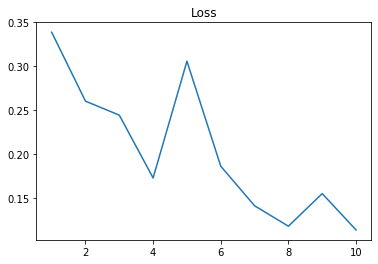

In [5]:
import matplotlib.pyplot as plt
x=[0.33888888,0.26051247,0.24460389,0.17317185,0.30594814,0.18654576,0.14153522,0.11828711,0.15537623,0.11406663]
y=[i for i in range(1,11)]
plt.plot(y,x)
plt.title('Loss')

### Demo test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


time cost 0.052  pnet 0.022  rnet 0.018  onet 0.012
(1, 5)


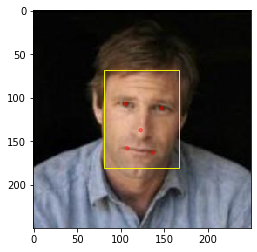

In [13]:
import cv2
if __name__ == '__main__':

    #trained model
    p_model_path = "./model_store/pnet_epoch_10.pt"
    r_model_path = "./model_store/rnet_epoch_10.pt"
    o_model_path = "./model_store/onet_model_final.pt"#"./model_store/landmark/onet_epoch_10.pt"
    pnet, rnet, onet = create_mtcnn_net(p_model_path=p_model_path, r_model_path=r_model_path, o_model_path=o_model_path, use_cuda=False)
    mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24,threshold=[0.6, 0.7, 0.7])

    img = cv2.imread("./6.jpg")
    img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bboxs, landmarks = mtcnn_detector.detect_face(img)
    print(bboxs.shape)
    
    # print box_align
    save_name = './r_6.jpg'
    vis_face(img_bg,bboxs,landmarks, save_name)


### Use my model to detect the face and do the face alignment according to the landmark

In [14]:

import os
import cv2
import numpy
import logging
import tensorflow as tf
 
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
 
# different size of the final images and their target coordinates
imgSize1 = [112,96]
imgSize2 = [112,112]
coord5point1 = [[30.2946, 51.6963],  # 112x96
               [65.5318, 51.6963],
               [48.0252, 71.7366],
               [33.5493, 92.3655],
               [62.7299, 92.3655]]
coord5point2 = [[30.2946+8.0000, 51.6963], # 112x112
               [65.5318+8.0000, 51.6963],
               [48.0252+8.0000, 71.7366],
               [33.5493+8.0000, 92.3655],
               [62.7299+8.0000, 92.3655]]
 
def transformation_from_points(points1, points2):
    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)
    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = numpy.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return numpy.vstack([numpy.hstack(((s2 / s1) * R,c2.T - (s2 / s1) * R * c1.T)),numpy.matrix([0., 0., 1.])])
 
def warp_im(img_im, orgi_landmarks,tar_landmarks):
    pts1 = numpy.float64(numpy.matrix([[point[0], point[1]] for point in orgi_landmarks]))
    pts2 = numpy.float64(numpy.matrix([[point[0], point[1]] for point in tar_landmarks]))
    M = transformation_from_points(pts1, pts2)
    dst = cv2.warpAffine(img_im, M[:2], (img_im.shape[1], img_im.shape[0]))
    return dst
 
def main():   
    pic_path = './testalign'
    p_model_path = "./model_store/pnet_epoch_10.pt"
    r_model_path = "./model_store/rnet_epoch_10.pt"
    o_model_path = "./model_store/onet_model_final.pt"
    pnet, rnet, onet = create_mtcnn_net(p_model_path=p_model_path, r_model_path=r_model_path, o_model_path=o_model_path, use_cuda=False)
    mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24,threshold=[0.6, 0.7, 0.7])
    
    lower_threshold = 100
    upper_threshold = 200
    num = 0
 
    pic_name_list = os.listdir(pic_path)
    for every_pic_name in pic_name_list:
        #print(every_pic_name)
        img_im = cv2.imread(os.path.join(pic_path , every_pic_name))
        #print(pic_path + every_pic_name)
        if img_im is None:
            continue
        else:
            shape = img_im.shape
            height = shape[0]
            width = shape[1]
            bounding_boxes, points = mtcnn_detector.detect_face(img_im)
            
            if bounding_boxes.shape[0] > 0:
                for i in range(bounding_boxes.shape[0]):  # how many bounding boxes
                    print(i)
                    x1, y1, x2, y2 = int(min(bounding_boxes[i][0], min(points[i][:5]))), \
                                     int(min(bounding_boxes[i][1], min(points[i][5:]))), \
                                     int(max(bounding_boxes[i][2], max(points[i][:5]))), \
                                     int(max(bounding_boxes[i][3], max(points[i][5:])))
                    new_x1 = max(int(1.50 * x1 - 0.50 * x2),0)
                    new_x2 = min(int(1.50 * x2 - 0.50 * x1),width-1)
                    new_y1 = max(int(1.50 * y1 - 0.50 * y2),0)
                    new_y2 = min(int(1.50 * y2 - 0.50 * y1),height-1)
                    
 
                    # original landmarks
                    left_eye_x = points[i][:5][0]
                    right_eye_x = points[i][:5][1]
                    nose_x = points[i][:5][2]
                    left_mouth_x = points[i][:5][3]
                    right_mouth_x = points[i][:5][4]
                    left_eye_y = points[i][5:][0]
                    right_eye_y = points[i][5:][1]
                    nose_y = points[i][5:][2]
                    left_mouth_y = points[i][5:][3]
                    right_mouth_y = points[i][5:][4]
 
                    # updated landmarks
                    new_left_eye_x = left_eye_x - new_x1
                    new_right_eye_x = right_eye_x - new_x1
                    new_nose_x = nose_x - new_x1
                    new_left_mouth_x = left_mouth_x - new_x1
                    new_right_mouth_x = right_mouth_x - new_x1
                    new_left_eye_y = left_eye_y - new_y1
                    new_right_eye_y = right_eye_y - new_y1
                    new_nose_y = nose_y - new_y1
                    new_left_mouth_y = left_mouth_y - new_y1
                    new_right_mouth_y = right_mouth_y - new_y1
 
                    face_landmarks = [[new_left_eye_x,new_left_eye_y], 
                                      [new_right_eye_x,new_right_eye_y],
                                      [new_nose_x,new_nose_y],
                                      [new_left_mouth_x,new_left_mouth_y],
                                      [new_right_mouth_x,new_right_mouth_y]]
                    face = img_im[new_y1: new_y2, new_x1: new_x2] 
                    dst1 = warp_im(face,face_landmarks,coord5point1) # 112x96
                    dst2 = warp_im(face,face_landmarks,coord5point2) # 112x112
                    crop_im1 = dst1[0:imgSize1[0],0:imgSize1[1]]
                    crop_im2 = dst2[0:imgSize2[0],0:imgSize2[1]]
                    cv2.imwrite(os.path.join(pic_path , every_pic_name[:-4] + '_' + str(num) + '_align_112x96.jpg'),crop_im1)
                    cv2.imwrite(os.path.join(pic_path , every_pic_name[:-4] + '_' + str(num) + '_align_112x112.jpg'),crop_im2)
                    num = num + 1

In [15]:
if __name__ == '__main__':
    main()
    cv2.waitKey()
    pass


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time cost 0.166  pnet 0.056  rnet 0.100  onet 0.010
0
time cost 0.176  pnet 0.083  rnet 0.084  onet 0.009
0
time cost 0.088  pnet 0.046  rnet 0.039  onet 0.003
0
time cost 0.451  pnet 0.217  rnet 0.207  onet 0.027
0
